###### 【問題1】自作データセットでの分類の学習
自作のデータセットに対して分類問題を解いてください。任意の実装を使用してください。

In [2]:
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import glob

Using TensorFlow backend.


In [3]:
folder = ["USAGI","AHIRU"]
image_size =  128
 
X = []
Y = []
filename = []
for index, name in enumerate(folder):
    dir = "./" + name
    files = glob.glob(dir + "/*.JPG")
    for i, file in enumerate(files):
        print(file)
        filename.append(str(file))
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        data = np.asarray(image)
        X.append(data)
        Y.append(index)
 
X = np.array(X)
Y = np.array(Y)

./USAGI/KIMG2621.JPG
./USAGI/KIMG2624.JPG
./AHIRU/KIMG2623.JPG
./AHIRU/KIMG2622.JPG
./AHIRU/KIMG2625.JPG


In [4]:
X = X.astype('float32')
X = X / 255.0

In [5]:
# 正解ラベルの形式を変換
Y = np_utils.to_categorical(Y, 2)

In [6]:
for i in range(len(Y)):
    print("Input={} Class={}".format(filename[i], np.argmax(Y[i])))

Input=./USAGI/KIMG2621.JPG Class=0
Input=./USAGI/KIMG2624.JPG Class=0
Input=./AHIRU/KIMG2623.JPG Class=1
Input=./AHIRU/KIMG2622.JPG Class=1
Input=./AHIRU/KIMG2625.JPG Class=1


USAGI = 0  
AHIRU = 1

In [7]:
X_train = X
y_train = Y

In [43]:
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0)

In [8]:
# CNNを構築
model = Sequential()

print(X_train.shape[1:])

model.add(Conv2D(32, (3, 3), padding='same',input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))
 
# コンパイル
model.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])

(128, 128, 3)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
history = model.fit(X_train, y_train, epochs=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
5/5 [==============================] - 1s 256ms/step - loss: 0.6512 - acc: 0.6000
Epoch 2/10
5/5 [==============================] - 0s 95ms/step - loss: 0.6456 - acc: 0.8000
Epoch 3/10
5/5 [==============================] - 0s 92ms/step - loss: 0.6832 - acc: 0.6000
Epoch 4/10
5/5 [==============================] - 0s 91ms/step - loss: 0.6994 - acc: 0.6000
Epoch 5/10
5/5 [==============================] - 0s 91ms/step - loss: 0.6878 - acc: 0.6000
Epoch 6/10
5/5 [==============================] - 0s 95ms/step - loss: 0.6541 - acc: 0.6000
Epoch 7/10
5/5 [==============================] - 0s 95ms/step - loss: 0.5845 - acc: 0.6000
Epoch 8/10
5/5 [==============================] - 0s 98ms/step - loss: 0.6259 - acc: 0.6000
Epoch 9/10
5/5 [==============================] - 0s 98ms/step - loss: 0.6557 - acc: 0.6000
Epoch 10/10
5/5 [==============================] - 0s 92ms/step - loss: 0.6996 - acc: 0.4000


###### TEST

In [10]:
folder = ["test"]
image_size = 128
 
X_test = []
for index, name in enumerate(folder):
    dir = "./" + name
    files = glob.glob(dir + "/*.JPG")
    for i, file in enumerate(files):
        print(file)
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        data = np.asarray(image)
        X_test.append(data)
        #Y.append(index)
 
X_test = np.array(X_test)
#Y = np.array(Y)

./test/KIMG2626.JPG


In [11]:
X_test = X_test.astype('float32')
X_test = X_test / 255.0

In [12]:
pred = model.predict(X_test)
print("Result=",pred)
print("Predicted class=[{}]".format(np.argmax(pred)))

Result= [[0.40354186 0.59645814]]
Predicted class=[1]


<img src="test/KIMG2626.JPG">

結果、上のイメージはアヒルと認識された。（答えはうさぎらしい。。。）

###### pipeline

In [13]:
from sklearn.metrics import accuracy_score

###### 【問題2】分類データセットに対するデータ拡張
データ拡張（Data Augmentation）を行ってください。

In [14]:
%matplotlib inline

In [15]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.color import label2rgb

import albumentations as A
import random

BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2, **kwargs):
    #height, width = img.shape[:2]

    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    return img

def visualize_titles(img, bbox, title, color=BOX_COLOR, thickness=2, font_thickness = 2, font_scale=0.35, **kwargs):
    #height, width = img.shape[:2]
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    
    ((text_width, text_height), _) = cv2.getTextSize(title, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, title, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, font_scale, TEXT_COLOR,
                font_thickness, lineType=cv2.LINE_AA)
    return img


def augment_and_show(aug, image, mask=None, bboxes=[], categories=[], category_id_to_name=[], filename=None, 
                     font_scale_orig=0.35, 
                     font_scale_aug=0.35, show_title=True, **kwargs):

    augmented = aug(image=image, mask=mask, bboxes=bboxes, category_id=categories)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_aug = cv2.cvtColor(augmented['image'], cv2.COLOR_BGR2RGB)

    for bbox in bboxes:
        visualize_bbox(image, bbox, **kwargs)

    for bbox in augmented['bboxes']:
        visualize_bbox(image_aug, bbox, **kwargs)

    if show_title:
        for bbox,cat_id in zip(bboxes, categories):
            visualize_titles(image, bbox, category_id_to_name[cat_id], font_scale=font_scale_orig, **kwargs)
        for bbox,cat_id in zip(augmented['bboxes'], augmented['category_id']):
            visualize_titles(image_aug, bbox, category_id_to_name[cat_id], font_scale=font_scale_aug, **kwargs)

    
    if mask is None:
        f, ax = plt.subplots(1, 2, figsize=(16, 8))
        
        ax[0].imshow(image)
        ax[0].set_title('Original image')
        
        ax[1].imshow(image_aug)
        ax[1].set_title('Augmented image')
    else:
        f, ax = plt.subplots(2, 2, figsize=(16, 16))
        
        if len(mask.shape) != 3:
            mask = label2rgb(mask, bg_label=0)            
            mask_aug = label2rgb(augmented['mask'], bg_label=0)
        else:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask_aug = cv2.cvtColor(augmented['mask'], cv2.COLOR_BGR2RGB)
            
        ax[0, 0].imshow(image)
        ax[0, 0].set_title('Original image')
        
        ax[0, 1].imshow(image_aug)
        ax[0, 1].set_title('Augmented image')
        
        ax[1, 0].imshow(mask, interpolation='nearest')
        ax[1, 0].set_title('Original mask')

        ax[1, 1].imshow(mask_aug, interpolation='nearest')
        ax[1, 1].set_title('Augmented mask')

    f.tight_layout()
    if filename is not None:
        f.savefig(filename)
        
    return augmented['image'], augmented['mask'], augmented['bboxes']

def find_in_dir(dirname):
    return [os.path.join(dirname, fname) for fname in sorted(os.listdir(dirname))]

In [16]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose
)

##### Color

In [17]:
random.seed(42)
image = cv2.imread('./USAGI/KIMG2621.JPG')

light = A.Compose([
    A.RandomBrightnessContrast(p=1),    
    A.RandomGamma(p=1),    
    A.CLAHE(p=1),    
], p=1)

medium = A.Compose([
    A.CLAHE(p=1),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=50, val_shift_limit=50, p=1),
], p=1)


strong = A.Compose([
    A.ChannelShuffle(p=1),
], p=1)

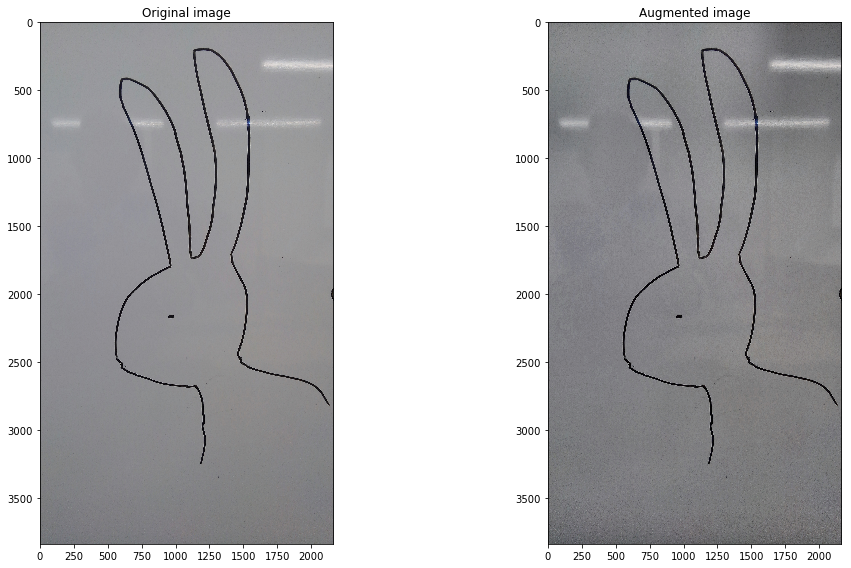

In [18]:
r = augment_and_show(light, image)

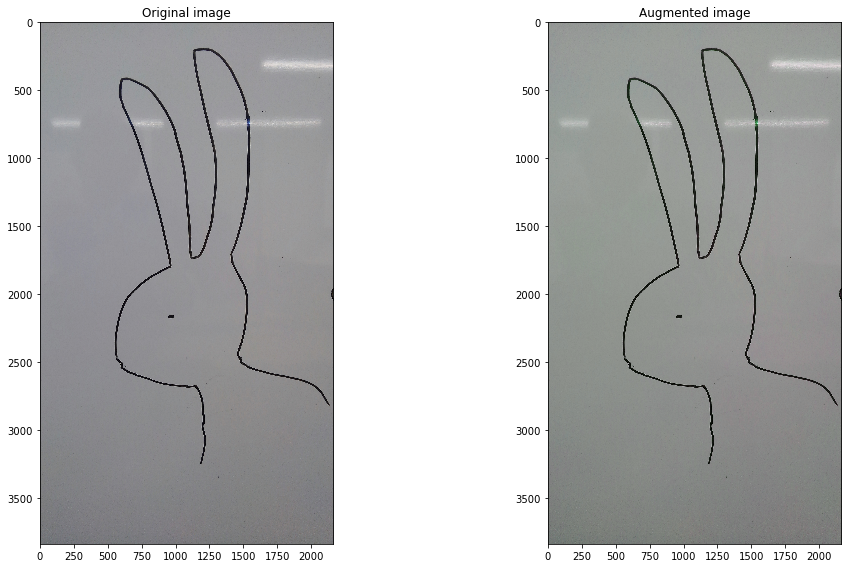

In [19]:
r = augment_and_show(strong, image)

##### 取りあえず回す

In [20]:
image = cv2.imread('./USAGI/KIMG2621.JPG')

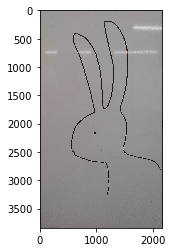

In [21]:
plt.imshow(np.array(image))

In [22]:
aug = Compose(
    [HorizontalFlip(0.2),
     ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=90, p=.5),
     OneOf([RandomContrast(), RandomBrightness(),], p=0.3)], 
    p=0.8) 

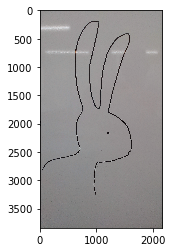

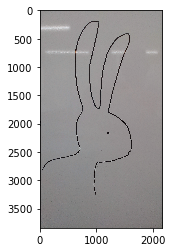

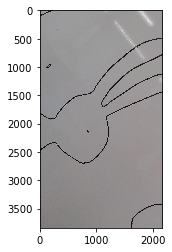

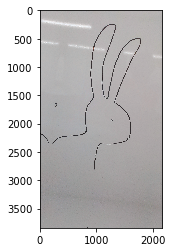

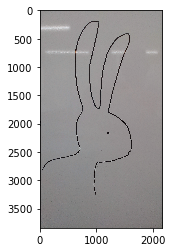

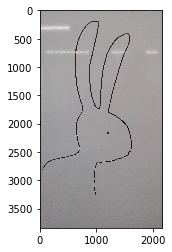

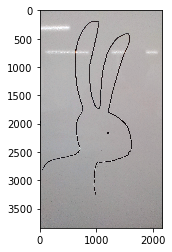

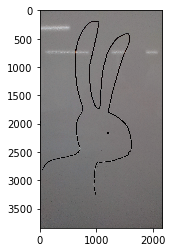

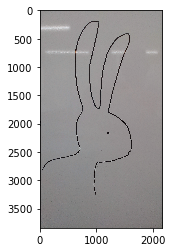

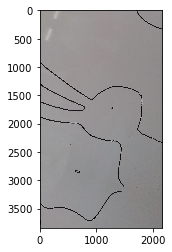

In [23]:
for _ in range(10):
    auged_img= aug(image=image)["image"]
    plt.imshow(np.array(auged_img))
    plt.show()

###### 関数

In [24]:
IMAGE_SIZE = 256
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [25]:
def create_model(data_shape):
    # CNNを構築
    print("data_size=", data_shape)
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=data_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])
    
    return model

In [42]:
def run_training(model, augmentation, n_epoch=10, n_aug=20, image_size = 128):
    folder = ["USAGI","AHIRU"]

    X = []
    Y = []
    filename = []
    for index, name in enumerate(folder):
        dir = "./" + name
        files = glob.glob(dir + "/*.JPG")
        for i, file in enumerate(files):
            #print(file)
            filename.append(str(file))
            image = Image.open(file)
            image = image.convert("RGB")
            image = image.resize((image_size, image_size))
            data = np.asarray(image)

            #Augmentation 
            for _ in range(n_aug):
                data = augmentation(image=data)["image"]
                X.append(data)
                Y.append(index)

    X = np.array(X)
    Y = np.array(Y)
    X = X.astype('float32')
    X = X / 255.0 #RGB正規化

    # 正解ラベルの形式を変換
    Y = np_utils.to_categorical(Y, 2)

    #sprit
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    
    history = model.fit(X_train, y_train, epochs=n_epoch, validation_split=0.2)
    #print("", model.evaluate(X_test, y_test))
    pred = model.predict(X_test)
    #print(pred)
    pred_class = np.argmax(pred, axis=1)
    ans_class = np.argmax(y_test, axis=1)
    print("Predicted class=[{}]".format(pred_class))
    print("Answer class=[{}]".format(ans_class))
    
    print("accuracy=",accuracy_score(pred_class, ans_class))

###### 何もしない（同じデータを複製）

In [27]:
aug = Compose(
    [HorizontalFlip(0.0)],
    p=0.0) 

In [251]:
run_training(create_model(data_shape = INPUT_SHAPE), aug, n_epoch=20, n_aug=20, image_size = IMAGE_SIZE)

data_size= (256, 256, 3)
Train on 64 samples, validate on 16 samples
Epoch 1/20
64/64 [==============================] - 32s 498ms/step - loss: 0.7904 - acc: 0.5312 - val_loss: 0.7023 - val_acc: 0.2500
Epoch 2/20
64/64 [==============================] - 18s 288ms/step - loss: 0.6734 - acc: 0.6094 - val_loss: 0.6259 - val_acc: 0.7500
Epoch 3/20
64/64 [==============================] - 18s 275ms/step - loss: 0.6575 - acc: 0.6406 - val_loss: 0.6190 - val_acc: 0.7500
Epoch 4/20
64/64 [==============================] - 18s 274ms/step - loss: 0.6516 - acc: 0.6406 - val_loss: 0.6032 - val_acc: 0.7500
Epoch 5/20
64/64 [==============================] - 18s 274ms/step - loss: 0.6517 - acc: 0.6406 - val_loss: 0.6083 - val_acc: 0.7500
Epoch 6/20
64/64 [==============================] - 18s 286ms/step - loss: 0.6539 - acc: 0.6406 - v

###### フリップのみでやってみる

In [241]:
aug = Compose(
    [Flip(0.5)],
    p=0.5) 

In [242]:
run_training(create_model(data_shape = INPUT_SHAPE), aug, n_epoch=20, n_aug=20, image_size = IMAGE_SIZE)

data_size= (256, 256, 3)
Train on 64 samples, validate on 16 samples
Epoch 1/20
64/64 [==============================] - 32s 497ms/step - loss: 0.8384 - acc: 0.5781 - val_loss: 0.7115 - val_acc: 0.4375
Epoch 2/20
64/64 [==============================] - 20s 320ms/step - loss: 0.7094 - acc: 0.5156 - val_loss: 0.6884 - val_acc: 0.5625
Epoch 3/20
64/64 [==============================] - 18s 278ms/step - loss: 0.6839 - acc: 0.6250 - val_loss: 0.6874 - val_acc: 0.5625
Epoch 4/20
64/64 [==============================] - 17s 272ms/step - loss: 0.6853 - acc: 0.6250 - val_loss: 0.6869 - val_acc: 0.5625
Epoch 5/20
64/64 [==============================] - 19s 290ms/step - loss: 0.6452 - acc: 0.6250 - val_loss: 0.6859 - val_acc: 0.5625
Epoch 6/20
64/64 [==============================] - 20s 306ms/step - loss: 0.6763 - acc: 0.6250 - v

###### 回転のみでやってみる

In [243]:
aug = Compose(
    [ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=.5)],
    p=0.5) 

In [244]:
run_training(create_model(data_shape = INPUT_SHAPE), aug, n_epoch=20, n_aug=20, image_size = IMAGE_SIZE)

data_size= (256, 256, 3)
Train on 64 samples, validate on 16 samples
Epoch 1/20
64/64 [==============================] - 31s 487ms/step - loss: 0.7457 - acc: 0.5469 - val_loss: 0.9911 - val_acc: 0.3125
Epoch 2/20
64/64 [==============================] - 22s 342ms/step - loss: 0.9252 - acc: 0.4688 - val_loss: 0.6582 - val_acc: 0.6875
Epoch 3/20
64/64 [==============================] - 20s 308ms/step - loss: 0.6742 - acc: 0.5938 - val_loss: 0.6639 - val_acc: 0.6875
Epoch 4/20
64/64 [==============================] - 20s 308ms/step - loss: 0.6877 - acc: 0.6094 - val_loss: 0.6656 - val_acc: 0.6875
Epoch 5/20
64/64 [==============================] - 19s 290ms/step - loss: 0.6720 - acc: 0.6250 - val_loss: 0.6686 - val_acc: 0.6875
Epoch 6/20
64/64 [==============================] - 19s 304ms/step - loss: 0.6819 - acc: 0.5781 -

##### フリップ +  回転 

In [246]:
aug = Compose(
    [ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=.5)],
    [Flip(0.5)],
    p=0.5) 

In [247]:
run_training(create_model(data_shape = INPUT_SHAPE), aug, n_epoch=20, n_aug=20, image_size = IMAGE_SIZE)

data_size= (256, 256, 3)
Train on 64 samples, validate on 16 samples
Epoch 1/20
64/64 [==============================] - 34s 534ms/step - loss: 0.6093 - acc: 0.6719 - val_loss: 0.7004 - val_acc: 0.5000
Epoch 2/20
64/64 [==============================] - 22s 338ms/step - loss: 0.9241 - acc: 0.6406 - val_loss: 0.7015 - val_acc: 0.5000
Epoch 3/20
64/64 [==============================] - 21s 333ms/step - loss: 0.8002 - acc: 0.3906 - val_loss: 0.6999 - val_acc: 0.5000
Epoch 4/20
64/64 [==============================] - 23s 355ms/step - loss: 0.6424 - acc: 0.6719 - val_loss: 0.7078 - val_acc: 0.5000
Epoch 5/20
64/64 [==============================] - 23s 357ms/step - loss: 0.6213 - acc: 0.6719 - val_loss: 0.7135 - val_acc: 0.5000
Epoch 6/20
64/64 [==============================] - 21s 326ms/step - loss: 0.6307 - acc: 0.67

###### SCALE (Random, shift, rotationはしない)

In [248]:
aug = Compose(
    [ShiftScaleRotate(shift_limit=0.0, scale_limit=0.5, rotate_limit=0, p=.5)],
    [Flip(0.5)],
    p=0.5) 

In [249]:
run_training(create_model(data_shape = INPUT_SHAPE), aug, n_epoch=20, n_aug=20, image_size = IMAGE_SIZE)

data_size= (256, 256, 3)
Train on 64 samples, validate on 16 samples
Epoch 1/20
64/64 [==============================] - 28s 445ms/step - loss: 1.0546 - acc: 0.5625 - val_loss: 0.9282 - val_acc: 0.3125
Epoch 2/20
64/64 [==============================] - 19s 294ms/step - loss: 0.9676 - acc: 0.4062 - val_loss: 0.6887 - val_acc: 0.6875
Epoch 3/20
64/64 [==============================] - 19s 291ms/step - loss: 0.6949 - acc: 0.4688 - val_loss: 0.6798 - val_acc: 0.6875
Epoch 4/20
64/64 [==============================] - 17s 265ms/step - loss: 0.6867 - acc: 0.6094 - val_loss: 0.6758 - val_acc: 0.6875
Epoch 5/20
64/64 [==============================] - 17s 268ms/step - loss: 0.6893 - acc: 0.5938 - val_loss: 0.6726 - val_acc: 0.6875
Epoch 6/20
64/64 [==============================] - 17s 258ms/step - loss: 0.6702 - acc: 0.6094 - v

###### augmentationの枚数を増やす

In [28]:
aug = Compose(
    [ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=.5)],
    [Flip(0.5)],
    p=0.5) 

In [29]:
model = create_model(data_shape = INPUT_SHAPE)

data_size= (256, 256, 3)


In [30]:
run_training(model, aug, n_epoch=20, n_aug=50, image_size = IMAGE_SIZE)

Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 58s 365ms/step - loss: 0.7193 - acc: 0.5875 - val_loss: 0.6783 - val_acc: 0.6000
Epoch 2/20
160/160 [==============================] - 42s 264ms/step - loss: 0.6988 - acc: 0.5750 - val_loss: 0.6747 - val_acc: 0.6000
Epoch 3/20
160/160 [==============================] - 42s 264ms/step - loss: 0.6957 - acc: 0.5875 - val_loss: 0.6794 - val_acc: 0.

In [31]:
#スマホで撮ったデータが逆さまなため反転させる
aug = Compose(
    [ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=180, p=1)],
    p=1) 

./test2/KIMG2632.JPG


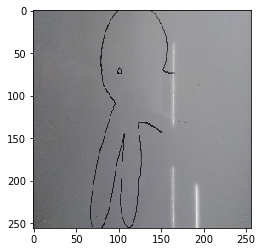

./test2/KIMG2627.JPG


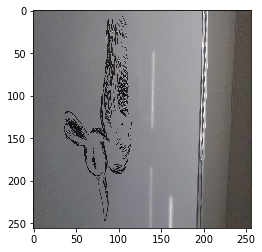

./test2/KIMG2630.JPG


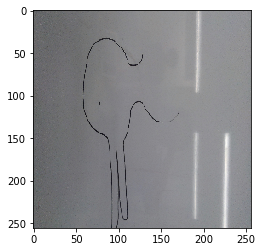

./test2/KIMG2629.JPG


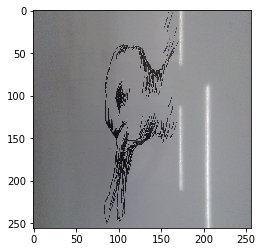

./test2/KIMG2628.JPG


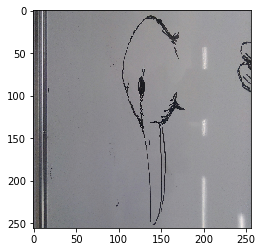

In [38]:
folder = ["test2"]

X_test = []
for index, name in enumerate(folder):
    dir = "./" + name
    files = glob.glob(dir + "/*.JPG")
    for i, file in enumerate(files):
        print(file)
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
        #イメージの反転
        plt.imshow(np.array(image))
        plt.show()
        
        data = np.asarray(image)
        data = aug(image=data)['image']
        X_test.append(data)
        #Y.append(index)
 
X_test = np.array(X_test)

In [41]:
#RGB正規化
X_test = X_test.astype('float32')
X_test = X_test / 255.0

In [40]:
pred = model.predict(X_test)
print("Result=",pred)
print("Predicted class=[{}]".format(np.argmax(pred, axis=1)))

Result= [[0.47074902 0.529251  ]
 [0.4722299  0.5277701 ]
 [0.47261438 0.5273856 ]
 [0.46992537 0.5300746 ]
 [0.4690238  0.53097624]]
Predicted class=[[1 1 1 1 1]]


USAGI = 0  
AHIRU = 1  

結果、全てアヒルとなった。しかし各ラベルの確率を見るとその差は僅差だった。

###### 【問題4】物体検出データセットの用意
次に、物体検出を行います。バウンディングボックスのアノテーションを行い物体検出のためのデータセットを作成してください。